# Kuzushiji Character Recognition

## Imports and Configuration
First, we need to import our libraries and set random seeds for when we do our train/test split

In [1]:
# import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
# reproducibility
np.random.seed(2021)
random.seed(2021)

## Dataset
Our dataset (Kuzishiji-49) already puts our data as numpy arrays, in a compressed `npz` format.

In [3]:
# load compressed numpy arrays

# train images
with np.load('./kuzushiji-49/k49-train-imgs.npz') as data:
    X_tr = data['arr_0']

# train labels
with np.load('./kuzushiji-49/k49-train-labels.npz') as data:
    Y_tr = data['arr_0']
    
# validation images
with np.load('./kuzushiji-49/k49-val-imgs.npz') as data:
    X_val = data['arr_0']

# validation labels
with np.load('./kuzushiji-49/k49-val-labels.npz') as data:
    Y_val = data['arr_0']

If we take a look at our labels, we can see that they're just uints, so no need to do any conversions. We are provided with a classmap that maps numbers to unicode characters. We'll load that and make a helpful function to convert a label to a character.

In [4]:
Y_val[:10]

array([19, 23, 10, 31, 26, 12, 24,  9, 24,  8], dtype=uint8)

In [5]:
# create lookup table + conversion function to convert label to UTF-8 char
lookup_df = pd.read_csv('./kuzushiji-49/k49_classmap.csv')
lookup_df = lookup_df[['codepoint', 'char']]

def label_to_char(label):
    return lookup_df.iloc[label]['char']

In [6]:
label_to_char(Y_val[:10])

19    と
23    ね
10    さ
31    み
26    ひ
12    す
24    の
9     こ
24    の
8     け
Name: char, dtype: object

Taking a look at the shapes of our data and the quantity of samples we have:

In [7]:
print("# of training instances:", X_tr.shape[0])
print("# of validation instances:", X_val.shape[0])
print("Total # of instances:", X_tr.shape[0] + X_val.shape[0])
print("\n")
print("Shape of training instance features:", X_tr.shape[1:])
print("Shape of validation instance features:", X_val.shape[1:])

# of training instances: 232365
# of validation instances: 38547
Total # of instances: 270912


Shape of training instance features: (28, 28)
Shape of validation instance features: (28, 28)


Instead of having features in the shape of (28, 28), let's reshape our features to (784,) so that we can easily manipulate these arrays.

In [8]:
X_tr.shape

(232365, 28, 28)

In [9]:
X_tr = X_tr.reshape((232365, 28*28))
X_tr.shape

(232365, 784)

In [10]:
X_val.shape

(38547, 28, 28)

In [11]:
X_val = X_val.reshape((38547, 28*28))
X_val.shape

(38547, 784)

We'll also make a helper function to display a given sample

In [12]:
def display_sample(sample, shape=(28,28), figsize=(4,4)):
    reshaped = sample.reshape(shape)
    scaled = sample * 255
    plt.axis('off')
#   plt.figure(figsize=figsize)
    plt.imshow(reshaped, cmap='Greys', interpolation='nearest')

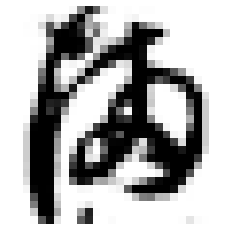

In [13]:
display_sample(X_tr[0])

## Preprocessing

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [23]:
scaler.fit(X_tr)
X_tr_scaled = scaler.transform(X_tr)

In [24]:
# scaler.fit(X_val)
X_val_scaled = scaler.transform(X_val)

In [25]:
X_tr_scaled.shape

(232365, 784)

In [42]:
X_tr_scaled[0][:25]

array([-0.05022437, -0.0752899 , -0.0985739 , -0.1263021 , -0.1586886 ,
       -0.19495544, -0.23656815, -0.28517693, -0.07149167,  1.9564926 ,
        3.08829427,  1.99801996,  0.18460652, -0.49427858, -0.55914342,
       -0.47865337, -0.46061543, -0.33699791, -0.28823661, -0.29083113,
       -0.24735166, -0.20969678, -0.17497405, -0.14251326, -0.11260953])

## Naive Bayes

In [27]:
# import NaiveBayes from sklearn 
from sklearn.naive_bayes import CategoricalNB
kzsj_nb = CategoricalNB()

In [28]:
kzsj_nb.fit(X_tr_scaled, Y_tr)

CategoricalNB()

In [29]:
y_pred = kzsj_nb.predict(X_val_scaled)
y_pred[:10]

array([19, 23, 48,  3, 32, 21, 24, 44, 24,  8], dtype=uint8)

In [30]:
Y_val[:10]

array([19, 23, 10, 31, 26, 12, 24,  9, 24,  8], dtype=uint8)

In [31]:
print(classification_report(y_pred, Y_val, labels=[i for i in range(49)]))

              precision    recall  f1-score   support

           0       0.30      0.46      0.36       651
           1       0.73      0.81      0.77       897
           2       0.84      0.45      0.58      1892
           3       0.53      0.24      0.33       284
           4       0.52      0.67      0.58       781
           5       0.14      0.37      0.21       390
           6       0.19      0.36      0.25       541
           7       0.49      0.54      0.52       905
           8       0.30      0.21      0.25      1101
           9       0.35      0.65      0.46       542
          10       0.47      0.60      0.53       771
          11       0.55      0.23      0.32      2452
          12       0.10      0.20      0.13       483
          13       0.47      0.50      0.49       645
          14       0.38      0.43      0.40       562
          15       0.23      0.35      0.27       652
          16       0.67      0.45      0.54       614
          17       0.39    